# CNN Model Training

## Import Common Libraries

In [1]:
import numpy as np

## Define paths

In [2]:
cnn_features_dir = "../data/features/audio_16k/augmented_mel_spectrograms/audio_features"
metadata_dir = "../data/features/audio_16k/augmented_mel_spectrograms/metadata.csv"
checkpoints_model_dir = "../models/cnn/checkpoints"
final_model_dir = "../models/cnn/final"

## Ensure dir exist

In [3]:
import os

os.makedirs(checkpoints_model_dir, exist_ok=True)
os.makedirs(final_model_dir, exist_ok=True)

## Load Metadata

In [4]:
import pandas as pd

df = pd.read_csv(metadata_dir)
print(f"Total samples: {len(df)}")

Total samples: 56590


## Encode labels for CNN

In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

# Prepare labels
le = LabelEncoder()
y_int = le.fit_transform(df['emotion'])      # convert emotions to integers
y_onehot = to_categorical(y_int) # one-hot encoding for softmax

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_int), y=y_int)
class_weight_dict = dict(enumerate(class_weights))

num_classes = len(le.classes_)
inverse_map = {idx: cls for idx, cls in enumerate(le.classes_)}

print("Number of classes:", num_classes)
print(inverse_map)

2025-12-04 20:57:10.928277: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-04 20:57:11.018609: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-04 20:57:12.274119: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Number of classes: 6
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad'}


## Train/test split

In [6]:
from sklearn.model_selection import train_test_split

file_paths = df['file_path'].values

# First split: separate out test set (true holdout)
train_val_paths, test_paths, y_train_val, y_test = train_test_split(
    file_paths, y_onehot, test_size=0.15, stratify=y_int, random_state=42
)

# Second split: separate train and validation
train_paths, val_paths, y_train, y_val = train_test_split(
    train_val_paths, y_train_val, test_size=0.176, stratify=np.argmax(y_train_val, axis=1), random_state=42
)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Test samples: {len(test_paths)}")

Training samples: 39635
Validation samples: 8466
Test samples: 8489


## Create Generators

In [7]:
import sys
sys.path.append("../src")
import classes
from classes import AudioDataGenerator

train_gen = AudioDataGenerator(train_paths, y_train, batch_size=32, shuffle=True)
val_gen = AudioDataGenerator(val_paths, y_val, batch_size=32, shuffle=False)
test_gen = AudioDataGenerator(test_paths, y_test, batch_size=32, shuffle=False)

print(f"Training batches per epoch: {len(train_gen)}")
print(f"Validation batches per epoch: {len(train_gen)}")
print(f"Test batches: {len(test_gen)}")

Training batches per epoch: 1239
Validation batches per epoch: 1239
Test batches: 266


## Define CNN Architecture

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, GlobalAveragePooling2D, Input

input_shape = (128, 150, 1)

model = Sequential([
    Input(input_shape),

    # BLOCK 1: Early features
    Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    # BLOCK 2: Mid-level features
    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    # BLOCK 3: High-level features
    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.5),

    # TRANSITION: 2D → 1D
    GlobalAveragePooling2D(),
    
    # CLASSIFICATION
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.6),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.6),
    Dense(num_classes, activation='softmax')
])

I0000 00:00:1764853041.923786   63090 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


## Compile the model

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(
        monitor='val_accuracy', 
        patience=15, 
        restore_best_weights=True,
        mode='max'
    ), # Stops training if there is no improvement in 10 epochsa
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=7, 
        min_lr=1e-7,
        verbose=1
    ), # Reduces learning rate if there is no improvement on val_loss
    ModelCheckpoint(
        filepath=f"{checkpoints_model_dir}/best_cnn_model.keras", 
        monitor="val_accuracy", 
        save_best_only=True, 
        mode="max", 
        verbose=1
    ) # Saves the best model in the training
]

## Train the Model

In [10]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


2025-12-04 20:57:26.064199: I external/local_xla/xla/service/service.cc:163] XLA service 0x76275801ac20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-04 20:57:26.064227: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-12-04 20:57:26.161146: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-04 20:57:26.710343: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-12-04 20:57:27.062152: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-04 20:57:27.

 455/1239 ━━━━━━━━━━━━━━━━━━━━ 1:08 87ms/step - accuracy: 0.2048 - loss: 3.1156

2025-12-04 20:58:23.845094: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-04 20:58:23.845157: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-04 20:58:23.845191: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-04 20:58:23.845200: I external/l

1239/1239 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.2452 - loss: 2.7715

2025-12-04 20:59:48.678581: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_352', 20 bytes spill stores, 20 bytes spill loads

2025-12-04 20:59:56.591223: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-04 20:59:56.591283: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-04 20:59:57.185323: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 


Epoch 1: val_accuracy improved from None to 0.31349, saving model to ../models/cnn/checkpoints/best_cnn_model.keras
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 157s 110ms/step - accuracy: 0.3000 - loss: 2.4126 - val_accuracy: 0.3135 - val_loss: 2.3203 - learning_rate: 5.0000e-04
Epoch 2/100
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4192 - loss: 1.9465
Epoch 2: val_accuracy improved from 0.31349 to 0.44543, saving model to ../models/cnn/checkpoints/best_cnn_model.keras
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 117s 94ms/step - accuracy: 0.4486 - loss: 1.8628 - val_accuracy: 0.4454 - val_loss: 1.8966 - learning_rate: 5.0000e-04
Epoch 3/100
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5047 - loss: 1.6532
Epoch 3: val_accuracy did not improve from 0.44543
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 120s 96ms/step - accuracy: 0.5222 - loss: 1.5935 - val_accuracy: 0.4264 - val_loss: 1.7235 - learning_rate: 5.0000e-04
Epoch 4/100
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5549 - loss:

## Make Predictions

In [11]:
# Predict probabilities
y_pred_prob = model.predict(test_gen)

# Convert to class indices
y_pred = np.argmax(y_pred_prob, axis=1)

# True labels as class indices
y_true = np.argmax(y_test, axis=1)

266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step


## Evaluate Model

### Accuracy, Precision, Recall, F1-score

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-score: {f1:.4f}")

Accuracy: 0.8616
Weighted Precision: 0.8741
Weighted Recall: 0.8616
Weighted F1-score: 0.8620


### Confusion Matrix

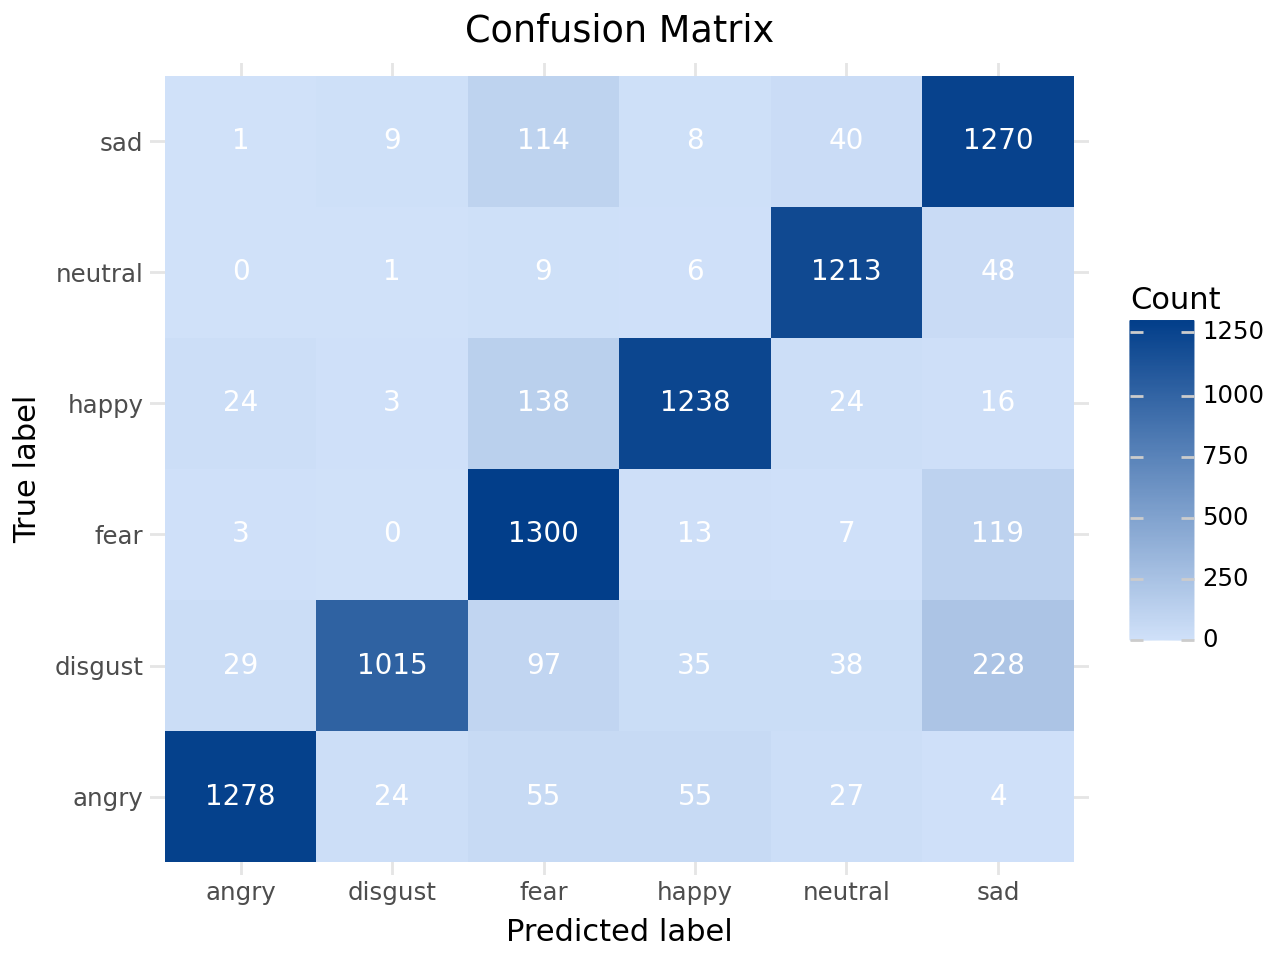

In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from plotnine import *

# Convert numeric labels → emotion names
true_labels = [inverse_map[i] for i in y_true]
pred_labels = [inverse_map[i] for i in y_pred]

# Compute confusion matrix
labels = sorted(list(inverse_map.values()))
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

# Convert to tidy DataFrame for plotnine
df_cm = (
    pd.DataFrame(cm, index=labels, columns=labels)
      .reset_index()
      .melt(id_vars='index')
)

df_cm.columns = ['True', 'Predicted', 'Count']

# Plot confusion matrix
(
    ggplot(df_cm, aes('Predicted', 'True', fill='Count'))
    + geom_tile()
    + geom_text(aes(label='Count'), color='white', size=10)
    + scale_fill_gradient(low='#d0e1f9', high='#023e8a')
    + theme_minimal()
    + labs(title='Confusion Matrix', x='Predicted label', y='True label')
)

### Unweighted Average Recall (UAR)

In [14]:
uar = recall_score(y_true, y_pred, average='macro')
print(f"Unweighted Average Recall (UAR): {uar:.4f}")

Unweighted Average Recall (UAR): 0.8633


### Detailed classification report

In [15]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=le.classes_)
print(report)

              precision    recall  f1-score   support

       angry       0.96      0.89      0.92      1443
     disgust       0.96      0.70      0.81      1442
        fear       0.76      0.90      0.82      1442
       happy       0.91      0.86      0.88      1443
     neutral       0.90      0.95      0.92      1277
         sad       0.75      0.88      0.81      1442

    accuracy                           0.86      8489
   macro avg       0.87      0.86      0.86      8489
weighted avg       0.87      0.86      0.86      8489



## Save Model

In [16]:
model.save("../models/cnn/final/cnn-ser-model.keras")

## Validate model with other dataset

### Initialize Class Predictor

In [17]:
import sys
sys.path.append("../src")
import classes
from classes import CNNAudioPredictor

predictor = CNNAudioPredictor(
    model_path="../models/cnn/final/cnn-ser-model.keras",
    class_names=["angry", "disgust", "fear", "happy", "neutral", "sad"],
    target_shape=(128, 150),
    sample_rate=16000
)

Model loaded successfully!
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
Model input shape: (None, 128, 150, 1)


### Get Predictions

In [18]:
import pandas as pd

df = pd.read_csv('../data/processed/audio_16k/emovo/metadata.csv')
file_paths = df["file_path"].tolist()

labels_dict = dict(zip(df['file_path'], df['emotion']))

true_labels = df["emotion"].tolist()

results, metrics = predictor.evaluate(file_paths, true_labels, batch_size=32)

Predicting on 504 files...
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step

2025-12-04 23:59:45.440804: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-04 23:59:45.440910: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-04 23:59:45.917755: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_190', 28 bytes spill stores, 28 bytes spill loads

2025-12-04 23:59:46.298638: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 486ms/step

OVERALL METRICS
Accuracy:  0.3512 (35.12%)
Precision: 0.3784
Recall:    0.3512
F1 Score:  0.3243

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       angry       0.48      0.48      0.48        84
     disgust       0.14      0.04      0.06        84
        fear       0.27      0.79      0.40        84
       happy       0.38      0.19      0.25        84
     neutral       0.64      0.35      0.45        84
         sad       0.35      0.27      0.31        84

    accuracy                           0.35       504
   macro avg       0.38      0.35      0.32       504
weighted avg       0.38      0.35      0.32       504


CONFUSION MATRIX:
Predicted ->
True ↓         angry          disgust        fear           happy          neutral        sad            
angry          40             6              23             11             1              3              
disgust        9              3         